Mounted at /content/drive
Target column 'host_is_superhost_in_period' exists in the loaded dataset.

Training Random Forest...
Random Forest - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00, ROC AUC: 1.00

Training Gradient Boosting...
Gradient Boosting - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00, ROC AUC: 1.00

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:22:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00, ROC AUC: 1.00

Total Training Time: 52.80 seconds

Model Comparison:
                   Accuracy  Precision    Recall  F1-Score  ROC AUC
Random Forest      0.999677   0.999862  0.998485  0.999173      1.0
Gradient Boosting  1.000000   1.000000  1.000000  1.000000      1.0
XGBoost            1.000000   1.000000  1.000000  1.000000      1.0

Best Model: Gradient Boosting


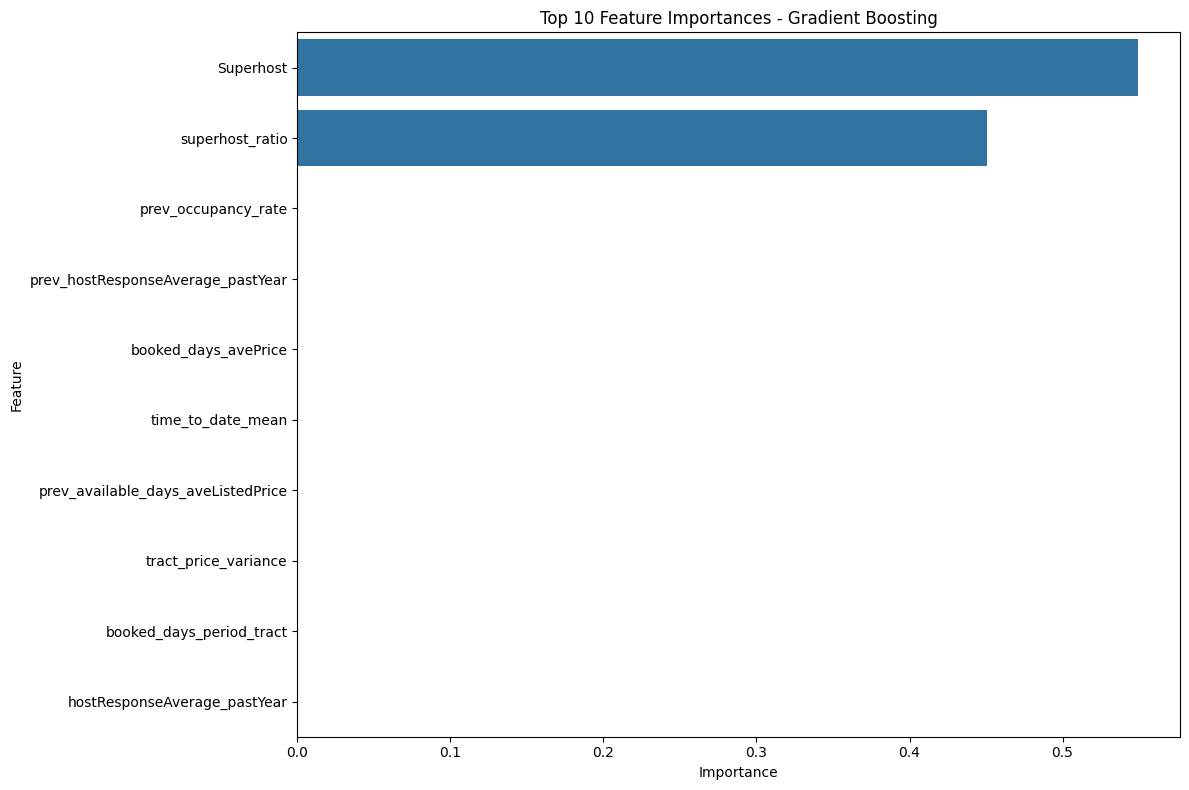


Model results saved to 'classification_results.csv'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time


# Load the dataset
file_name = "/content/drive/MyDrive/airbnb_Philadelphia.csv"  # Adjust file path
data = pd.read_csv(file_name)

# Ensure the target column exists
if 'host_is_superhost_in_period' not in data.columns:
    raise KeyError("'host_is_superhost_in_period' column is missing in the dataset!")

print("Target column 'host_is_superhost_in_period' exists in the loaded dataset.")

# Drop irrelevant columns
drop_columns = ['Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date']
data = data.drop(columns=drop_columns, errors='ignore')

# Fill missing values
data = data.fillna(data.median(numeric_only=True))  # Numeric columns
data = data.fillna("Unknown")  # Categorical columns

# Define preprocessing pipeline
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features.remove('host_is_superhost_in_period')  # Ensure target is excluded

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define features and target
target_column = 'host_is_superhost_in_period'
features = data.drop(columns=[target_column], errors='ignore')
target = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# Define models with optimized parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
    )
}

# Evaluate models
results = {}
start_time = time.time()
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

print(f"\nTotal Training Time: {time.time() - start_time:.2f} seconds")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Plot feature importance for the best model
best_model_name = max(results, key=lambda k: results[k]['ROC AUC'])
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
pipeline.fit(X_train, y_train)

# Get feature importances
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = numerical_features + list(pipeline.named_steps['preprocessor']
                                                       .transformers_[1][1]
                                                       .get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("The selected model does not provide feature importances.")

# Save results to CSV
results_df.to_csv('classification_results.csv', index=True)
print("\nModel results saved to 'classification_results.csv'.")


Target column 'host_is_superhost_in_period' exists in the loaded dataset.

Training Random Forest...
Random Forest - Accuracy: 0.95, Precision: 0.93, Recall: 0.82, F1-Score: 0.87, ROC AUC: 0.99

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.97, Precision: 0.93, Recall: 0.93, F1-Score: 0.93, ROC AUC: 0.99

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:39:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.98, Precision: 0.94, Recall: 0.96, F1-Score: 0.95, ROC AUC: 1.00

Total Training Time: 100.75 seconds

Model Comparison:
                   Accuracy  Precision    Recall  F1-Score   ROC AUC
Random Forest      0.951842   0.926012  0.818758  0.869089  0.988408
Gradient Boosting  0.972116   0.928532  0.928660  0.928596  0.993866
XGBoost            0.979753   0.941280  0.955929  0.948548  0.996529

Best Model: XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:39:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


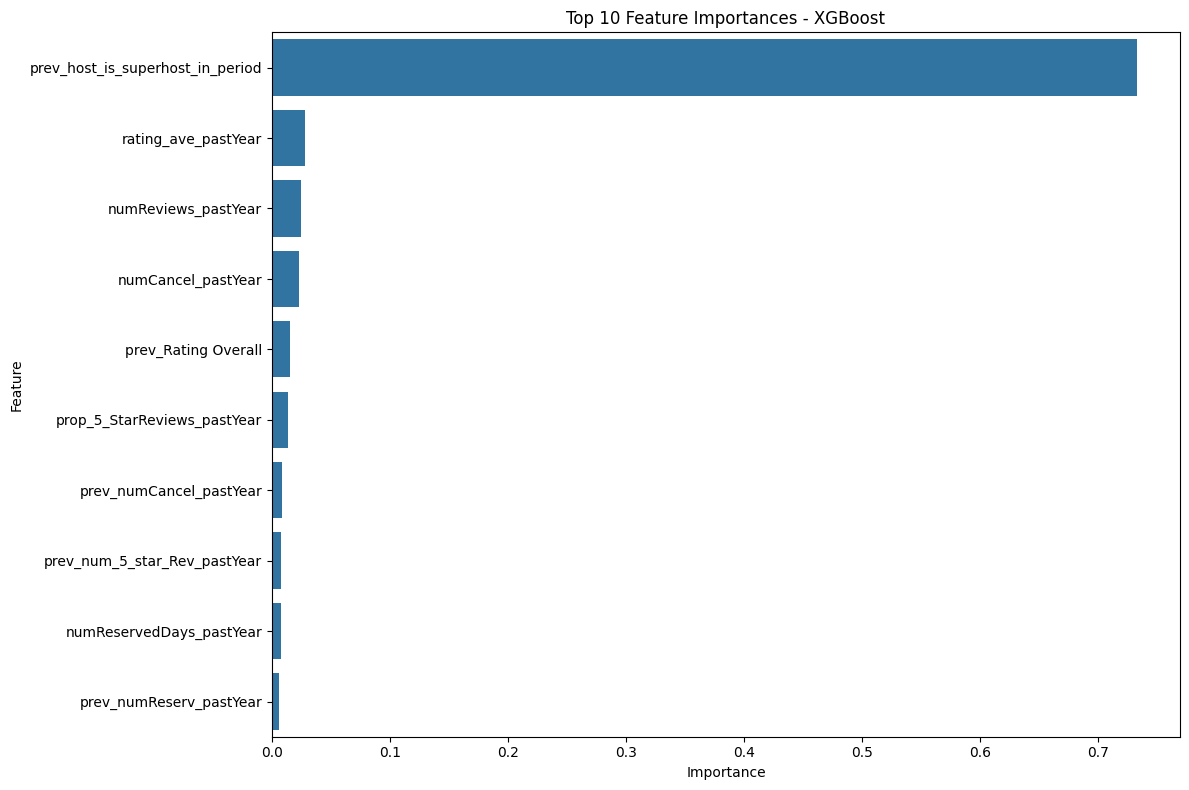


Model results saved to 'classification_results.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the dataset
file_name = "/content/drive/MyDrive/airbnb_Philadelphia.csv"  # Adjust file path
data = pd.read_csv(file_name)


# Ensure the target column exists
if 'host_is_superhost_in_period' not in data.columns:
    raise KeyError("'host_is_superhost_in_period' column is missing in the dataset!")

print("Target column 'host_is_superhost_in_period' exists in the loaded dataset.")

# Drop irrelevant columns and those providing direct knowledge of the target
drop_columns = ['Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date', 'Superhost', 'superhost_ratio', 'superhost_change', 'superhost_change_gain_superhost', 'superhost_change_lose_superhost', 'prev_host_is_superhost_in_preiod']
data = data.drop(columns=drop_columns, errors='ignore')

# Fill missing values
data = data.fillna(data.median(numeric_only=True))  # Numeric columns
data = data.fillna("Unknown")  # Categorical columns

# Define preprocessing pipeline
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features.remove('host_is_superhost_in_period')  # Ensure target is excluded

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define features and target
target_column = 'host_is_superhost_in_period'
features = data.drop(columns=[target_column], errors='ignore')
target = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# Define models with optimized parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
    )
}

# Evaluate models
results = {}
start_time = time.time()
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

print(f"\nTotal Training Time: {time.time() - start_time:.2f} seconds")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Plot feature importance for the best model
best_model_name = max(results, key=lambda k: results[k]['ROC AUC'])
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
pipeline.fit(X_train, y_train)

# Get feature importances
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = numerical_features + list(pipeline.named_steps['preprocessor']
                                                       .transformers_[1][1]
                                                       .get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("The selected model does not provide feature importances.")

# Save results to CSV
results_df.to_csv('classification_results.csv', index=True)
print("\nModel results saved to 'classification_results.csv'.")

Target column 'host_is_superhost_in_period' exists in the loaded dataset.

Training Random Forest...
Random Forest - Accuracy: 0.95, Precision: 0.93, Recall: 0.82, F1-Score: 0.87, ROC AUC: 0.99

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.97, Precision: 0.93, Recall: 0.93, F1-Score: 0.93, ROC AUC: 0.99

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:43:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.98, Precision: 0.94, Recall: 0.96, F1-Score: 0.95, ROC AUC: 1.00

Total Training Time: 102.12 seconds

Model Comparison:
                   Accuracy  Precision    Recall  F1-Score   ROC AUC
Random Forest      0.952622   0.929677  0.819309  0.871010  0.988364
Gradient Boosting  0.972116   0.928532  0.928660  0.928596  0.993865
XGBoost            0.979753   0.941280  0.955929  0.948548  0.996529

Best Model: XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:44:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


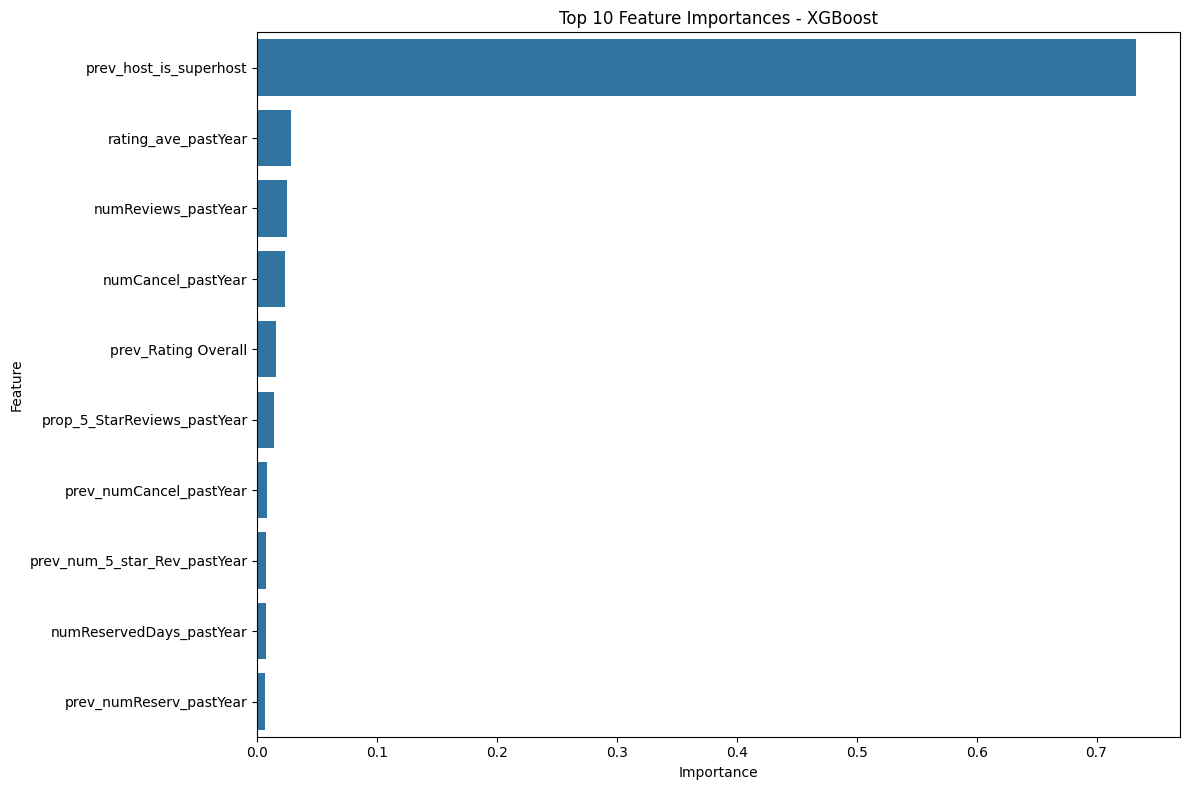


Model results saved to 'classification_results.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the dataset
file_name = "/content/drive/MyDrive/airbnb_Philadelphia.csv"  # Adjust file path
data = pd.read_csv(file_name)


# Ensure the target column exists
if 'host_is_superhost_in_period' not in data.columns:
    raise KeyError("'host_is_superhost_in_period' column is missing in the dataset!")

print("Target column 'host_is_superhost_in_period' exists in the loaded dataset.")

# Drop irrelevant columns and those providing direct knowledge of the target
drop_columns = ['Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date', 'Superhost', 'superhost_ratio', 'superhost_change', 'superhost_change_gain_superhost', 'superhost_change_lose_superhost', 'prev_host_is_superhost_in_period']
data = data.drop(columns=drop_columns, errors='ignore')

# Fill missing values
data = data.fillna(data.median(numeric_only=True))  # Numeric columns
data = data.fillna("Unknown")  # Categorical columns

# Define preprocessing pipeline
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features.remove('host_is_superhost_in_period')  # Ensure target is excluded

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define features and target
target_column = 'host_is_superhost_in_period'
features = data.drop(columns=[target_column], errors='ignore')
target = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# Define models with optimized parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
    )
}

# Evaluate models
results = {}
start_time = time.time()
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

print(f"\nTotal Training Time: {time.time() - start_time:.2f} seconds")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Plot feature importance for the best model
best_model_name = max(results, key=lambda k: results[k]['ROC AUC'])
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
pipeline.fit(X_train, y_train)

# Get feature importances
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = numerical_features + list(pipeline.named_steps['preprocessor']
                                                       .transformers_[1][1]
                                                       .get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("The selected model does not provide feature importances.")

# Save results to CSV
results_df.to_csv('classification_results.csv', index=True)
print("\nModel results saved to 'classification_results.csv'.")


Target column 'host_is_superhost_in_period' exists in the loaded dataset.

Training Random Forest...
Random Forest - Accuracy: 0.95, Precision: 0.93, Recall: 0.82, F1-Score: 0.87, ROC AUC: 0.99

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.97, Precision: 0.93, Recall: 0.93, F1-Score: 0.93, ROC AUC: 0.99

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:47:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.98, Precision: 0.94, Recall: 0.96, F1-Score: 0.95, ROC AUC: 1.00

Total Training Time: 105.61 seconds

Model Comparison:
                   Accuracy  Precision    Recall  F1-Score   ROC AUC
Random Forest      0.952622   0.929677  0.819309  0.871010  0.988364
Gradient Boosting  0.972116   0.928532  0.928660  0.928596  0.993865
XGBoost            0.979753   0.941280  0.955929  0.948548  0.996529

Best Model: XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:47:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


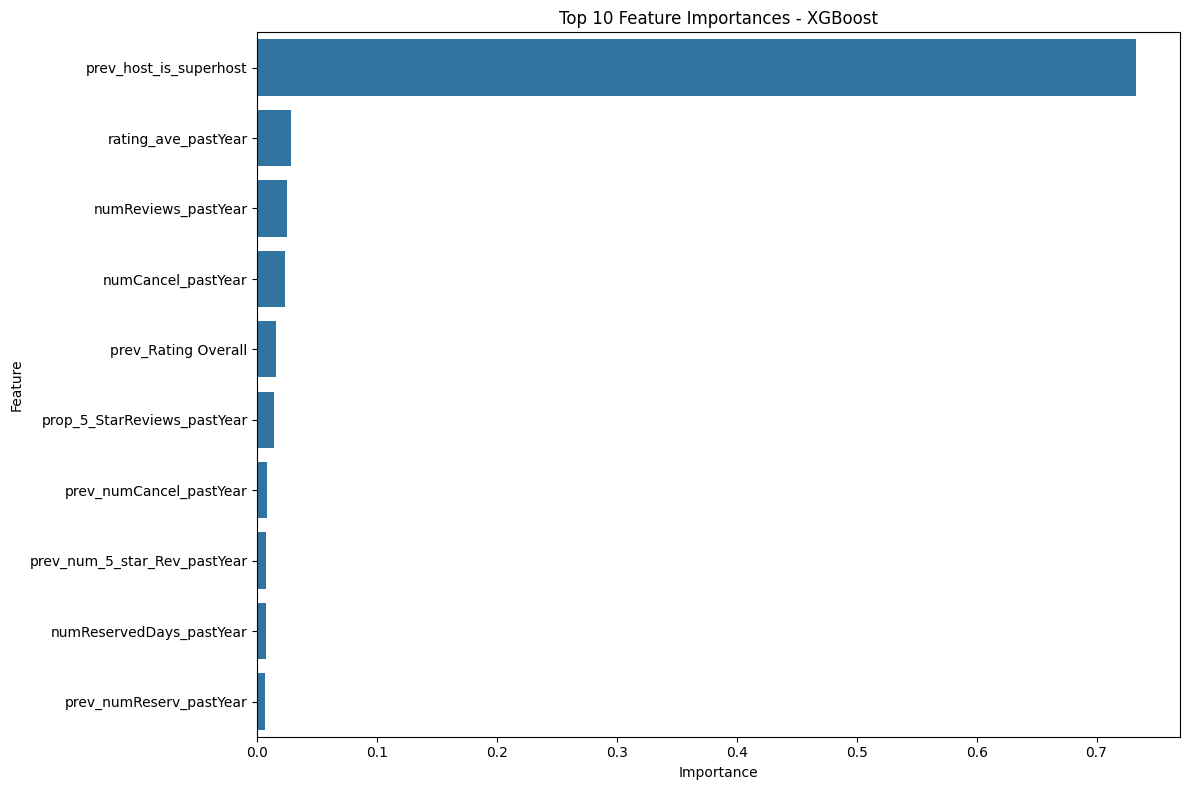


Model results saved to 'classification_results.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the dataset
file_name = "/content/drive/MyDrive/airbnb_Philadelphia.csv"  # Adjust file path
data = pd.read_csv(file_name)


# Ensure the target column exists
if 'host_is_superhost_in_period' not in data.columns:
    raise KeyError("'host_is_superhost_in_period' column is missing in the dataset!")

print("Target column 'host_is_superhost_in_period' exists in the loaded dataset.")

# Drop irrelevant columns and those providing direct knowledge of the target
drop_columns = ['Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date', 'Superhost', 'superhost_ratio', 'superhost_change', 'superhost_change_gain_superhost', 'superhost_change_lose_superhost', 'prev_host_is_superhost_in_period']
data = data.drop(columns=drop_columns, errors='ignore')

# Ensure the feature is dropped
if 'prev_host_is_superhost_in_period' in data.columns:
    print("Warning: 'prev_host_is_superhost_in_period' was not dropped. Dropping it now.")
    data = data.drop(columns=['prev_host_is_superhost_in_period'])

# Fill missing values
data = data.fillna(data.median(numeric_only=True))  # Numeric columns
data = data.fillna("Unknown")  # Categorical columns

# Define preprocessing pipeline
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features.remove('host_is_superhost_in_period')  # Ensure target is excluded

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define features and target
target_column = 'host_is_superhost_in_period'
features = data.drop(columns=[target_column], errors='ignore')
target = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# Define models with optimized parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
    )
}

# Evaluate models
results = {}
start_time = time.time()
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

print(f"\nTotal Training Time: {time.time() - start_time:.2f} seconds")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Plot feature importance for the best model
best_model_name = max(results, key=lambda k: results[k]['ROC AUC'])
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
pipeline.fit(X_train, y_train)

# Get feature importances
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = numerical_features + list(pipeline.named_steps['preprocessor']
                                                       .transformers_[1][1]
                                                       .get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("The selected model does not provide feature importances.")

# Save results to CSV
results_df.to_csv('classification_results.csv', index=True)
print("\nModel results saved to 'classification_results.csv'.")

Target column 'host_is_superhost_in_period' exists in the loaded dataset.

Training Random Forest...
Random Forest - Accuracy: 0.94, Precision: 0.92, Recall: 0.77, F1-Score: 0.84, ROC AUC: 0.98

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.97, Precision: 0.93, Recall: 0.91, F1-Score: 0.92, ROC AUC: 0.99

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:09:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.97, Precision: 0.93, Recall: 0.94, F1-Score: 0.93, ROC AUC: 0.99

Total Training Time: 96.53 seconds

Model Comparison:
                   Accuracy  Precision    Recall  F1-Score   ROC AUC
Random Forest      0.941785   0.915390  0.773309  0.838373  0.984372
Gradient Boosting  0.968163   0.925620  0.910067  0.917778  0.990214
XGBoost            0.974294   0.932027  0.936648  0.934332  0.993617

Best Model: XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:09:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


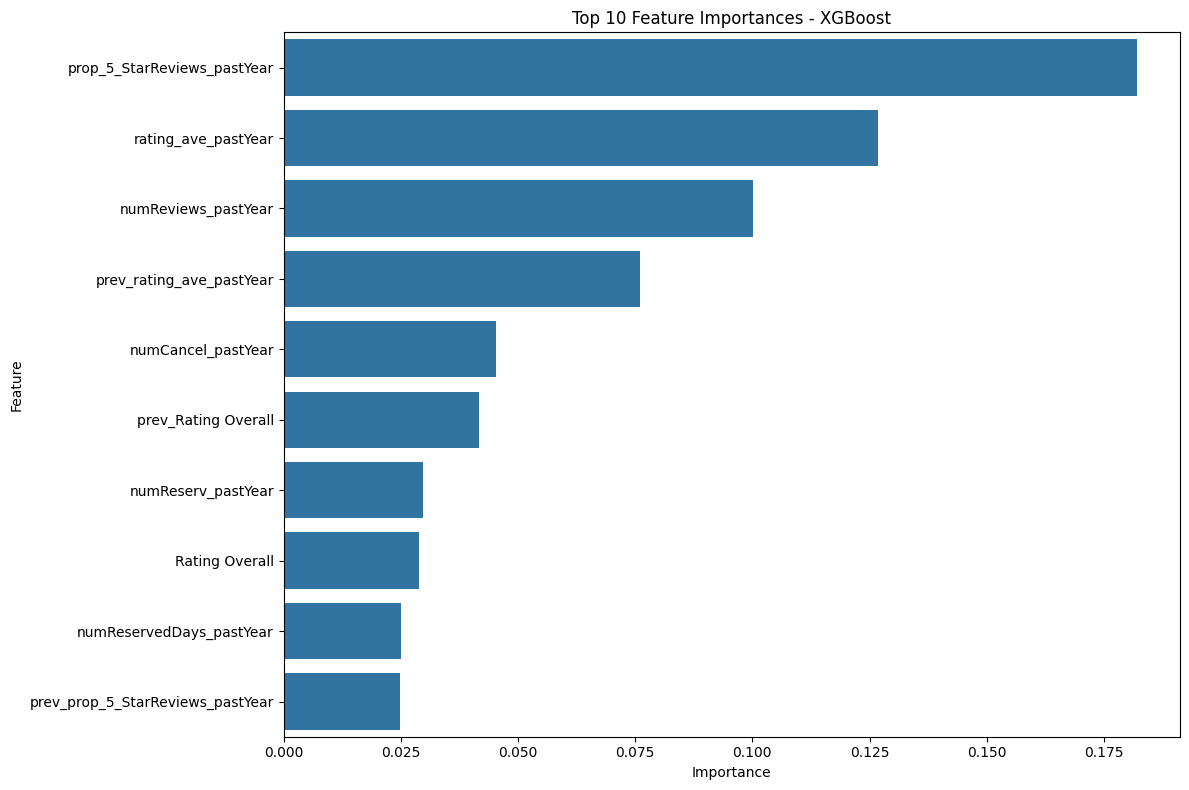


Model results saved to 'classification_results.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the dataset
file_name = "/content/drive/MyDrive/airbnb_Philadelphia.csv"  # Adjust file path
data = pd.read_csv(file_name)

# Ensure the target column exists
if 'host_is_superhost_in_period' not in data.columns:
    raise KeyError("'host_is_superhost_in_period' column is missing in the dataset!")

print("Target column 'host_is_superhost_in_period' exists in the loaded dataset.")

# Drop irrelevant columns and those providing direct knowledge of the target
drop_columns = [
    'Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date',
    'Superhost', 'superhost_ratio', 'superhost_change',
    'superhost_change_gain_superhost', 'superhost_change_lose_superhost',
    'prev_host_is_superhost', 'tract_superhosts_ratio',
    'tract_prev_superhosts', 'superhost_period_all',
    'superhost_observed_in_period', 'prev_superhost_period_all',
    'prev_host_is_superhost_in_period', 'superhost_date_diff',
    'tract_superhosts', 'prev_host_is_superhost1',
    'prev_host_is_superhost2', 'prev_year_superhosts', 'city_x'
]
data = data.drop(columns=drop_columns, errors='ignore')

# Ensure the feature is dropped
if 'prev_host_is_superhost_in_period' in data.columns:
    print("Warning: 'prev_host_is_superhost_in_period' was not dropped. Dropping it now.")
    data = data.drop(columns=['prev_host_is_superhost_in_period'])

# Fill missing values
data = data.fillna(data.median(numeric_only=True))  # Numeric columns
data = data.fillna("Unknown")  # Categorical columns

# Define features and target
target_column = 'host_is_superhost_in_period'
features = data.drop(columns=[target_column], errors='ignore')

# Ensure the feature is not present in the feature set
if 'prev_host_is_superhost_in_period' in features.columns:
    print("Error: 'prev_host_is_superhost_in_period' is still in the features. Dropping it.")
    features = features.drop(columns=['prev_host_is_superhost_in_period'])

target = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# Define preprocessing pipeline
categorical_features = features.select_dtypes(include=['object']).columns.tolist()
numerical_features = features.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define models with optimized parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
    )
}

# Evaluate models
results = {}
start_time = time.time()
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

print(f"\nTotal Training Time: {time.time() - start_time:.2f} seconds")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Plot feature importance for the best model
best_model_name = max(results, key=lambda k: results[k]['ROC AUC'])
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
pipeline.fit(X_train, y_train)

# Get feature importances
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = numerical_features + list(pipeline.named_steps['preprocessor']
                                                       .transformers_[1][1]
                                                       .get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("The selected model does not provide feature importances.")

# Save results to CSV
results_df.to_csv('classification_results.csv', index=True)
print("\nModel results saved to 'classification_results.csv'.")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     29929
         1.0       0.81      0.74      0.78      7261

    accuracy                           0.92     37190
   macro avg       0.88      0.85      0.86     37190
weighted avg       0.91      0.92      0.92     37190

ROC AUC Score: 0.96


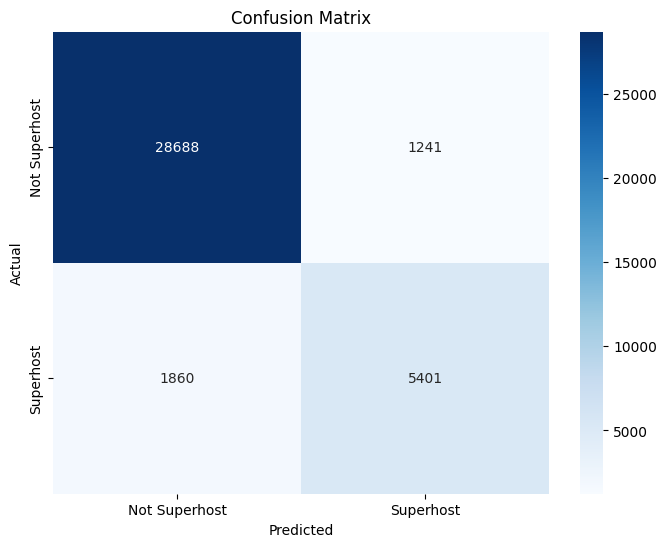

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the preprocessing pipeline for numerical and categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create a pipeline with preprocessing and logistic regression
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

# Train the logistic regression model
logistic_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = logistic_pipeline.predict(X_test)
y_proba = logistic_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Superhost', 'Superhost'], yticklabels=['Not Superhost', 'Superhost'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# **Nightly Rate Model**

Target column 'Nightly Rate' exists in the loaded dataset.

Training Random Forest...
Random Forest - MAE: 103.37, RMSE: 182.88, R2: 0.77

Training Gradient Boosting...
Gradient Boosting - MAE: 126.88, RMSE: 221.48, R2: 0.66

Training XGBoost...
XGBoost - MAE: 114.73, RMSE: 202.84, R2: 0.71

Model Comparison:
                          MAE        RMSE        R2
Random Forest      103.373071  182.878871  0.766556
Gradient Boosting  126.880521  221.477112  0.657617
XGBoost            114.729698  202.836432  0.712825

Best Model: Random Forest


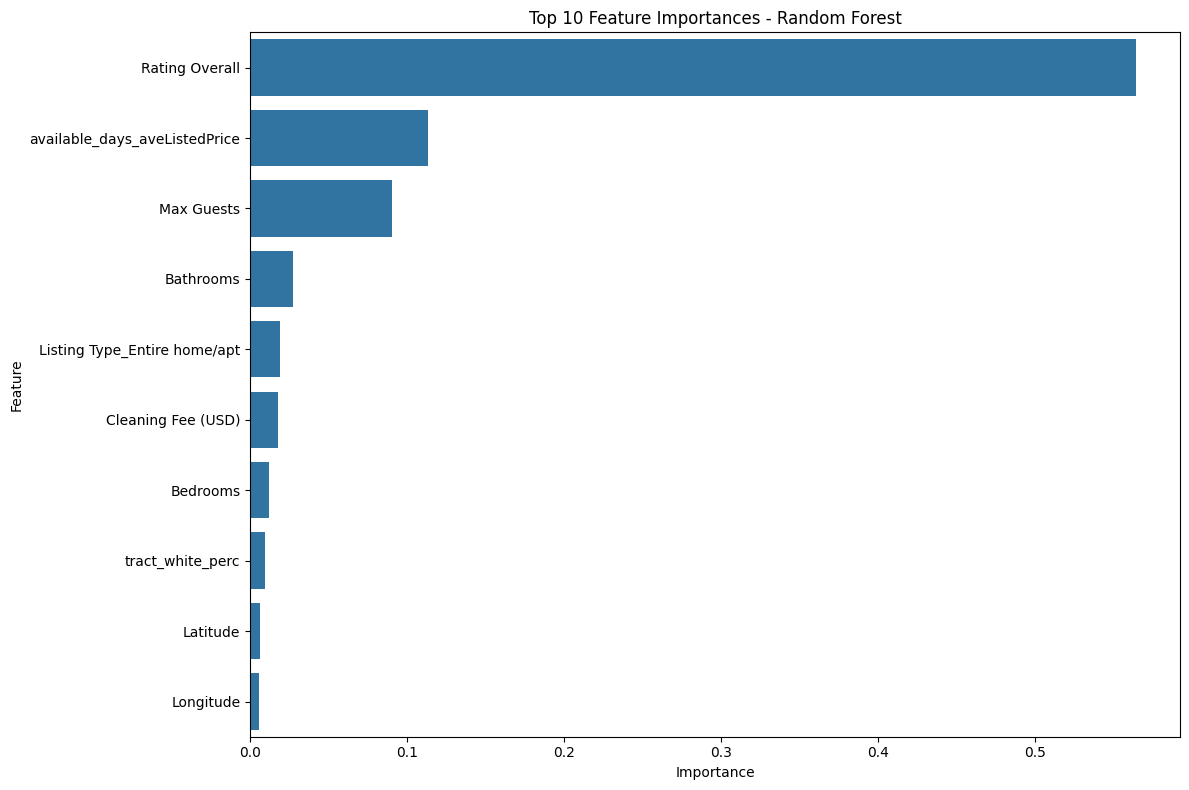


Model results saved to 'regression_results.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_name = "/content/drive/MyDrive/airbnb_Philadelphia.csv"  # Adjust file path
data = pd.read_csv(file_name)

# Ensure the target column exists
if 'Nightly Rate' not in data.columns:
    raise KeyError("'Nightly Rate' column is missing in the dataset!")

print("Target column 'Nightly Rate' exists in the loaded dataset.")

# Drop irrelevant columns
drop_columns = [
    'Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date', 'City_x',
    'prev_Nightly Rate', 'Nightly Rate_tractQuartile', 'prev_Nightly Rate_tractQuartile',
    'prev_Rating Overall', 'prev_available_days_aveListedPrice', 'tract_price_variance'
]
data = data.drop(columns=drop_columns, errors='ignore')

# Fill missing values
data = data.fillna(data.median(numeric_only=True))  # Numeric columns
data = data.fillna("Unknown")  # Categorical columns

# Define features and target
target_column = 'Nightly Rate'
features = data.drop(columns=[target_column], errors='ignore')
target = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Define preprocessing pipeline
categorical_features = features.select_dtypes(include=['object']).columns.tolist()
numerical_features = features.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define models with optimized parameters
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=50, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42
    )
}

# Evaluate models
results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Plot feature importance for the best model
best_model_name = max(results, key=lambda k: results[k]['R2'])
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])
pipeline.fit(X_train, y_train)

# Get feature importances
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = numerical_features + list(pipeline.named_steps['preprocessor']
                                                       .transformers_[1][1]
                                                       .get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("The selected model does not provide feature importances.")

# Save results to CSV
results_df.to_csv('regression_results.csv', index=True)
print("\nModel results saved to 'regression_results.csv'.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_name = "/content/drive/MyDrive/airbnb_Philadelphia.csv"  # Adjust file path
data = pd.read_csv(file_name)

# Verify the target column exists
if 'host_is_superhost_in_period' not in data.columns:
    raise KeyError("'host_is_superhost_in_period' column is missing in the dataset!")

print("Target column 'host_is_superhost_in_period' exists in the loaded dataset.")


Target column 'host_is_superhost_in_period' exists in the loaded dataset.


In [ ]:
# Drop columns that provide direct knowledge of the target or are irrelevant
drop_columns = [
    'Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date',
    'Superhost', 'superhost_ratio', 'superhost_change',
    'superhost_change_gain_superhost', 'superhost_change_lose_superhost',
    'prev_host_is_superhost_in_period'
]
data = data.drop(columns=drop_columns, errors='ignore')

# Verify problematic columns are dropped
assert 'prev_host_is_superhost_in_period' not in data.columns, "Feature prev_host_is_superhost_in_period is still present!"
print("Problematic columns successfully removed.")


Problematic columns successfully removed.


In [ ]:
# Fill missing values
data = data.fillna(data.median(numeric_only=True))  # Numeric columns
data = data.fillna("Unknown")  # Categorical columns


In [ ]:
# Define features and target
target_column = 'host_is_superhost_in_period'
features = data.drop(columns=[target_column], errors='ignore')
target = data[target_column]

# Verify again that no problematic feature is present
assert 'prev_host_is_superhost_in_period' not in features.columns, "Feature prev_host_is_superhost_in_period is still in features!"
print("Features and target are correctly defined.")


Features and target are correctly defined.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)


In [ ]:
# Identify categorical and numerical features
categorical_features = features.select_dtypes(include=['object']).columns.tolist()
numerical_features = features.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [ ]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss')
}


In [ ]:
# Train and evaluate models
results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }
    print(f"{model_name} - {results[model_name]}")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)



Training Random Forest...
Random Forest - {'Accuracy': 0.9526216724926055, 'Precision': 0.929676511954993, 'Recall': 0.8193086351742185, 'F1-Score': 0.8710102489019034, 'ROC AUC': 0.9883643320592703}

Training Gradient Boosting...


KeyboardInterrupt: 